#### In this file we will be training on the data generated from the dummy_data_gen_with_added_bugs script and drawing inferences on the Cross Validation set.

In [5]:
%run "consolidate_logs.py"
%run "compute_similarity.py"

In [ ]:
import pandas as pd
import numpy as np
import ast
import statistics
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import datetime
from consolidate_logs import consolidate_logs_in_time_window
from compute_similarity import get_similarity_scores

# =============================================================================
# Helper Functions
# =============================================================================

# Parse the Time_Window field which might either be a list or a single interval.
def parse_time_window(time_window_str):
    """
    Parses the Time_Window string into a list of (start, end) tuples.
    Expected formats:
      - "['2025-01-17 09:38:37 - 2025-01-17 11:10:29', ...]"
      - "2025-02-01 02:00:00 - 2025-02-01 06:00:00"
    """
    intervals = []
    try:
        # If the string looks like a list (begins with '['), use literal_eval
        if time_window_str.strip().startswith('['):
            windows = ast.literal_eval(time_window_str)
        else:
            windows = [time_window_str]
        # Each window should be of the form "start_time - end_time"
        for window in windows:
            parts = window.split(' - ')
            if len(parts) == 2:
                start_str, end_str = parts[0].strip(), parts[1].strip()
                start = pd.to_datetime(start_str)
                end = pd.to_datetime(end_str)
                intervals.append((start, end))
    except Exception as e:
        print("Error parsing time window:", e)
    return intervals

# Feature extraction from the consolidated logs DataFrame.
def extract_features_from_logs(df_logs, jira_ticket_row):
    """
    Extract features from the consolidated logs with extra focus on error/failure events.
    
    Features include:
      - Summary_Event_Name_Score: Score of the event name in the jira summary.
      - Summary_AS_Log_Score: Score of the event name in the jira summary.
      - Summary_BE_Log_Score: Score of the event name in the jira summary.
      - Summary_DD_Log_Score: Score of the event name in the jira summary.
      - Description_Event_Name_Score: Score of the event name in the jira description.
      - Description_AS_Log_Score: Score of the event name in the jira description.
      - Description_BE_Log_Score: Score of the event name in the jira description.
      - Description_DD_Log_Score: Score of the event name in the jira description.
    """
    features = {}
    if df_logs is None or df_logs.empty:
        features['summary_event_name_score'] = 0.0
        features['summary_as_log_score'] = 0.0
        features['summary_be_log_score'] = 0.0
        features['summary_dd_log_score'] = 0.0
        features['description_event_name_score'] = 0.0
        features['description_as_log_score'] = 0.0
        features['description_be_log_score'] = 0.0
        features['description_dd_log_score'] = 0.0
        return features

    summary = jira_ticket_row["Summary"]
    description = jira_ticket_row["Description"]
    
    # Define keywords to filter on (case-insensitive)
    keywords = ["error", "failure", "outage", "failed"]
    total_error_event_count = 0
    summary_event_name_score = 0
    summary_as_log_score = 0
    summary_be_log_score = 0
    summary_dd_log_score = 0
    description_event_name_score = 0
    description_as_log_score = 0
    description_be_log_score = 0
    description_dd_log_score = 0

    # Count error/failure occurrences either in event_name or in log_message
    for _, row in df_logs.iterrows():
        event_name = str(row.get("event_name", "")).lower()
        log_message_as = str(row.get("log_message", "")).lower()
        log_message_dd = str(row.get("log_message_dd", "")).lower()
        log_message_be = str(row.get("log_message_be", "")).lower()
        if any(keyword in event_name for keyword in keywords) or any(keyword in log_message_as for keyword in keywords):
            summary_event_name_score = statistics.mean(get_similarity_scores(event_name, summary).values())
            summary_as_log_score = statistics.mean(get_similarity_scores(log_message_as, summary).values())
            summary_be_log_score = statistics.mean(get_similarity_scores(log_message_be, summary).values())
            summary_dd_log_score = statistics.mean(get_similarity_scores(log_message_dd, summary).values())
            description_event_name_score = statistics.mean(get_similarity_scores(event_name, description).values())
            description_as_log_score = statistics.mean(get_similarity_scores(log_message_as, description).values())
            description_be_log_score = statistics.mean(get_similarity_scores(log_message_be, description).values())
            description_dd_log_score = statistics.mean(get_similarity_scores(log_message_dd, description).values())

    features['summary_event_name_score'] = summary_event_name_score
    features['summary_as_log_score'] = summary_as_log_score
    features['summary_be_log_score'] = summary_be_log_score
    features['summary_dd_log_score'] = summary_dd_log_score
    features['description_event_name_score'] = description_event_name_score
    features['description_as_log_score'] = description_as_log_score
    features['description_be_log_score'] = description_be_log_score
    features['description_dd_log_score'] = description_dd_log_score

    return features

def extract_static_features(row):
    """
    Extract static fields from the Jira ticket.
    You can customize which fields to include; here we add Project, Summary, and Description.
    """
    features = {}
    # features['Project'] = row.get("Project", "")
    features['Summary'] = row.get("Summary", "")
    features['Description'] = row.get("Description", "")
    # You can add more fields if needed.
    return features

# =============================================================================
# Training Phase
# =============================================================================

# Load your training data with the RCA labels.
df_training = pd.read_csv("jira_tickets_training.csv", parse_dates=["Created_Date"])

# Prepare lists to hold feature dictionaries and labels.
train_feature_dicts = []
train_labels = []

# For each training ticket, process its time windows to build features.
# For each Jira ticket, create a separate training example per time window.
for idx, row in df_training.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    # Extract static features that are common for all windows in this ticket.
    static_features = extract_static_features(row)
    label = row['RCA']
    
    # Create one training sample for each interval in the time window(s)
    for (start, end) in intervals:
        logs = consolidate_logs_in_time_window(start, end)
        log_features = extract_features_from_logs(logs, row)
        # Merge log-derived features with the static features from the ticket.
        combined_features = {**static_features, **log_features}
        train_feature_dicts.append(combined_features)
        train_labels.append(label)

# Vectorize the feature dictionaries.
dv = DictVectorizer(sparse=False)
X_train_features = dv.fit_transform(train_feature_dicts)

# Encode the RCA labels (assumes a limited set of unique RCAs).
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)

# For demonstration, split the training set for evaluation.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_features, y_train_encoded, test_size=0.1, random_state=42
)

# Train a RandomForest classifier.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)
y_val_pred = clf.predict(X_val)
print("Classification Report on Training Data:")
unique_labels = np.unique(y_val)
print(classification_report(
    y_val, 
    y_val_pred, 
    labels=unique_labels, 
    target_names=le.inverse_transform(unique_labels)
))

# =============================================================================
# Prediction Phase for jira_tickets_cv.csv
# =============================================================================

# Load CV tickets.
df_cv = pd.read_csv("jira_tickets_cv.csv", parse_dates=["Created_Date"])
cv_feature_dicts = []
cv_issue_ids = []

for idx, row in df_cv.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    static_features = extract_static_features(row)
    # Create one training sample per time window for this issue.
    for (start, end) in intervals:
        logs = consolidate_logs_in_time_window(start, end)
        log_features = extract_features_from_logs(logs, row)
        combined_features = {**static_features, **log_features}
        cv_feature_dicts.append(combined_features)
        # Save issue id; if multiple windows per issue, you might later aggregate predictions.
        cv_issue_ids.append(row['Issue_ID'])
# Transform the feature dictionary to match training features.
X_cv_features = dv.transform(cv_feature_dicts)
cv_preds = clf.predict(X_cv_features)
pred_rcas = le.inverse_transform(cv_preds)

# Combine predictions with their corresponding Issue_ID.
df_cv_predictions = pd.DataFrame({
    "Issue_ID": cv_issue_ids,
    "Predicted_RCA": pred_rcas
})
print("Predictions for jira_tickets_cv:")
df_cv_predictions

Classification Report on Training Data:
                                                                   precision    recall  f1-score   support

                                            Article vendor outage       1.00      1.00      1.00         4
Audio Service not returning soundbytes. Probably TTS Service Down       1.00      1.00      1.00         3
               Video Service Overloaded. Possibly Peak Time Issue       1.00      1.00      1.00         2

                                                         accuracy                           1.00         9
                                                        macro avg       1.00      1.00      1.00         9
                                                     weighted avg       1.00      1.00      1.00         9

Predictions for jira_tickets_cv:


,Issue_ID,Predicted_RCA
0,JIRA-CV-001,Article vendor outage
1,JIRA-CV-002,Video Service Overloaded. Possibly Peak Time I...
2,JIRA-CV-003,Login vendor is throwing an error. Please chec...
3,JIRA-CV-004,Audio Service not returning soundbytes. Probab...


##### validate your training and inference 

Misclassified Samples:
Empty DataFrame
Columns: [Description=Audio articles reported errors in this time window., Description=Sessions using Twitter login encountered failures for a prolonged period., Description=Too many video streaming failure events in this time window, Description=Users reported that AP articles were not loading in this time window, Summary=AP Articles not loading, Summary=NFL Video Streaming Failure, Summary=NYT Audio Articles Error, Summary=Twitter Login Failure, description_as_log_score, description_be_log_score, description_dd_log_score, description_event_name_score, summary_as_log_score, summary_be_log_score, summary_dd_log_score, summary_event_name_score, True_RCA, Predicted_RCA]
Index: []

Top features by importance:
                                              feature  importance
5                 Summary=NFL Video Streaming Failure    0.172842
2   Description=Too many video streaming failure e...    0.132091
6                    Summary=NYT Audio Articles

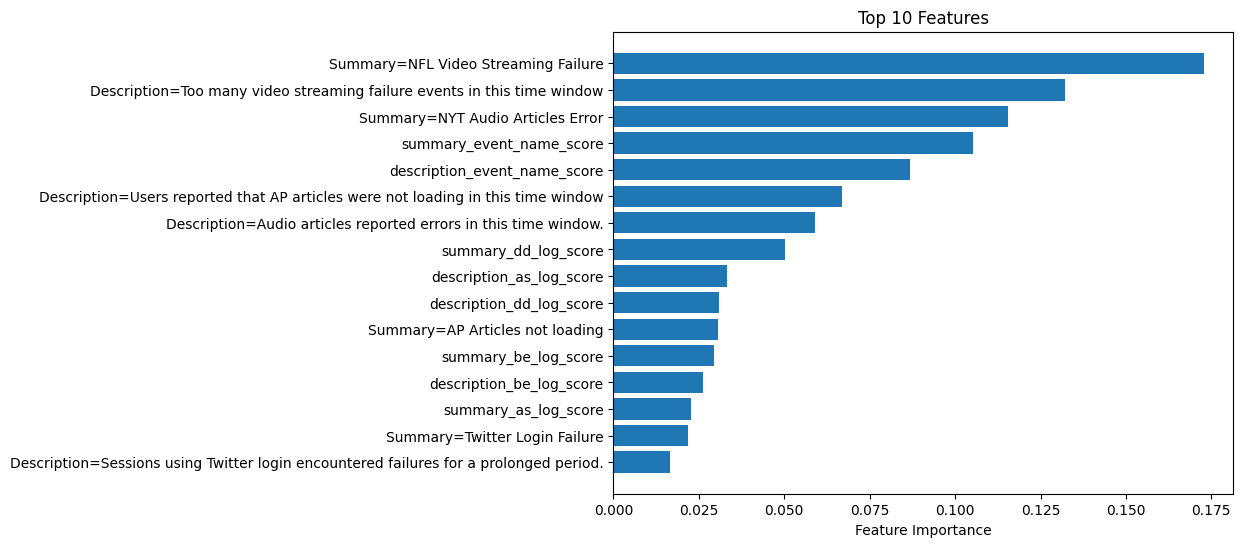

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Debugging: Compare Feature Vectors Between Correctly and Incorrectly Classified Samples --- #

# Suppose you have:
# - X_train_features: your feature matrix from the training phase (from DictVectorizer)
# - y_train_encoded: label-encoded true RCA values
# - clf: your trained RandomForest classifier
# - dv: your DictVectorizer object
# - le: your LabelEncoder object

# Get predictions on the training set.
def print_feature_vectors_importance():
    y_train_pred = clf.predict(X_train_features)

    # Create a DataFrame for easier comparison.
    feature_names = dv.get_feature_names_out()  # requires scikit-learn 1.0+
    df_features = pd.DataFrame(X_train_features, columns=feature_names)
    df_features['True_RCA'] = le.inverse_transform(y_train_encoded)
    df_features['Predicted_RCA'] = le.inverse_transform(y_train_pred)

    # Print samples where prediction was incorrect.
    misclassified = df_features[df_features['True_RCA'] != df_features['Predicted_RCA']]
    print("Misclassified Samples:")
    print(misclassified)

    # Optionally, if there is only one misclassification, examine it in detail:
    if misclassified.shape[0] == 1:
        print("Detailed view for the misclassified sample:")
        print(misclassified)  # Transposed view for easier comparison

    # --- Debugging: Feature Importance Analysis --- #

    importances = clf.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print("\nTop features by importance:")
    print(importance_df.head(10))

    # Plot the top 10 features to visually inspect which features are weighted highest.
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Features")
    plt.gca().invert_yaxis()  # Invert so the highest importance is on top
    plt.show()

print_feature_vectors_importance()